# 2. Regression: Predicting the distribution of the a dataset subjected to censorship (sample incompleteness)

In [1]:
import pandas as pd
from scipy.stats import norm
import matplotlib.pyplot as plt 
import numpy as np
import paramonte as pm

In [2]:
#downloads file from given url
def download(url, fpath):
    import requests
    r = requests.get(url)
    with open(fpath, 'wb') as f:
        f.write(r.content)
    return None

#fetching data file
def fetchDatafromWeb(filePath,url):
    download(url,filePath)
    return filePath

In [3]:
url='https://www.cdslab.org/recipes/programming/regression-censored-gaussian-data/data.csv'

In [4]:
fetchDatafromWeb(filePath="./data.csv", url=url)

'./data.csv'

In [5]:
df=pd.read_csv("./data.csv", header=None)
df.columns=["variable"]
df

,variable
0,0.20435
1,0.96737
2,0.62652
3,0.59974
4,0.83498
...,...
15022,0.38660
15023,1.46810
15024,1.47140
15025,0.21037


In [171]:
url2='https://www.cdslab.org/recipes/programming/regression-gaussian-data/dataFull.csv'
fetchDatafromWeb(filePath="./dataFull.txt", url=url2)
dfull=pd.read_csv("./dataFull.txt")
tail =dfull[dfull.variable.between(df["variable"].max(),10)]

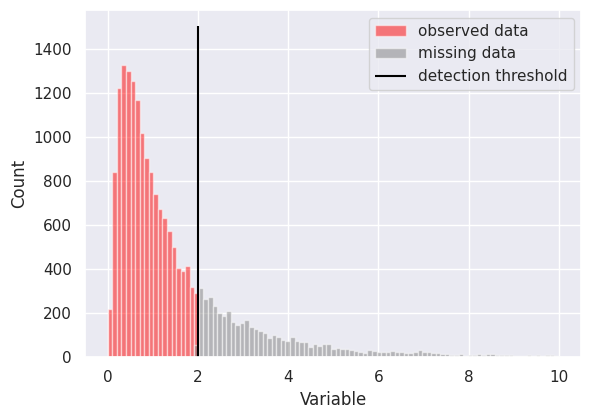

In [174]:
fig = plt.figure(figsize =(6.4,4.6), dpi =100)
bins = np.linspace(0, 10, 100)
plt.hist(df, bins, alpha=0.5, label='observed data', color ='red')
plt.hist(tail, bins, alpha=0.5, label='missing data', color ='gray')
plt.vlines(x=df.max(), ymin=0, ymax=1500,  color='black', label='detection threshold')
plt.legend(loc='upper right')
plt.ylabel('Count')
plt.xlabel('Variable');
plt.show()

In [173]:
ldata = np.double(np.log(df.iloc[:,0]))
ltail = np.double(np.log(tail.iloc[:,0]))

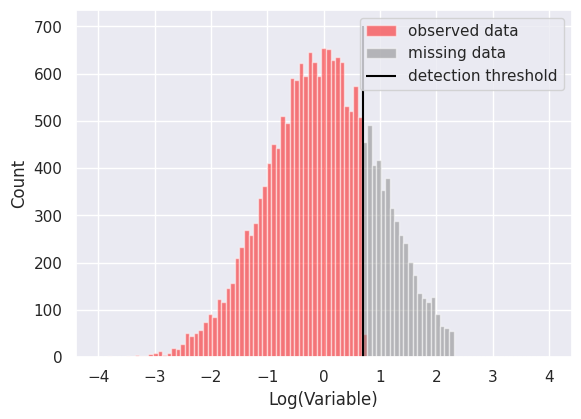

In [184]:
fig = plt.figure(figsize =(6.4,4.6), dpi =100)
bins = np.linspace(-4, 4, 100)
plt.hist(ldata, bins, alpha=0.5, label='observed data', color ='red')
plt.hist(ltail, bins, alpha=0.5, label='missing data', color ='gray')
plt.vlines(x=ldata.max(), ymin=0, ymax=700,  color='black', label='detection threshold')
plt.legend(loc='upper right')
plt.ylabel('Count')
plt.xlabel('Log(Variable)')
ax.set_xlim([-4, 4])
plt.show()

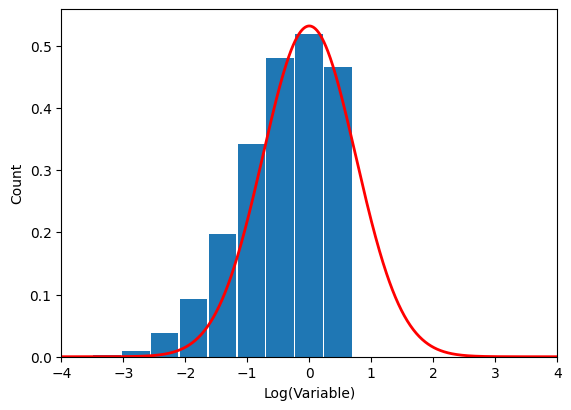

In [9]:
from scipy.stats import norm

ldata = np.double(np.log(df.iloc[:,0]))

tx= np.linspace(-4,4,1000)
ty= norm.pdf(tx, 0, .75)

fig = plt.figure(figsize =(6.4,4.6), dpi =100)
ax =plt.subplot()
ax.hist (ldata
         , bins =10
         , linewidth =0
         , histtype ='bar'
         , rwidth=0.95
         , density= True)

h = ax.plot ( tx
            , ty
            , color = 'r'
            , linewidth = 2
            )

ax.set_xlim([-4, 4])
plt.ylabel('Count')
plt.xlabel('Log(Variable)');
plt.show()

In [10]:
np.max(ldata)

0.6929971693088202

In [11]:
lthold = 0.693 

In [12]:
norm.cdf(lthold)

0.7558452242470381

In [52]:
from scipy.special import erf
def getTrunctNormCDF(x,mean,std): 
    return (1 + erf((x - mean) / std / np.sqrt(2))) / 2

In [121]:
#not including TrunctCDF
def getLogPDF(x, mean, lstd):
    std = np.exp(lstd)
    return -np.log(np.sqrt(2*np.pi)) - lstd - (x -mean)**2 / (2*std**2)

In [102]:
def getLogPDF(x, mean, lstd, cutoff):
    std = np.exp(lstd)
    return -np.log(np.sqrt(2*np.pi)) - lstd - (x -mean)**2 / (2*std**2) - np.log(getTrunctNormCDF(cutoff,mean,std)) 

In [66]:
def getNormPDF(x, mean, std):
    return  np.exp(-(x -mean)**2 / (2*std**2)) / (std * np.sqrt(2*np.pi))

In [53]:
#chcking function for cdf works
print(getTrunctNormCDF(x = ldata[0: 10000] , mean =0, std =1))
print(norm.cdf(ldata[0: 10000], 0, 1))

[0.05615209 0.48676782 0.32004442 ... 0.29907713 0.28824761 0.55118548]
[0.05615209 0.48676782 0.32004442 ... 0.29907713 0.28824761 0.55118548]


In [54]:
np.exp(getLogPDF( 0 ,0 ,np.log(1)))

0.7978845608028654

In [69]:
np.log(getNormPDF( 0 ,0 ,1))

-0.9189385332046727

In [103]:
def getLogLike(param):
    return np.sum(getLogPDF(x = ldata , mean =param [0], lstd =param[1], cutoff = lthold))

In [104]:
getLogLike( param = [0,0])
#2:03:00
#change axis titles

-14934.452245636443

In [21]:
print (pm.version.interface.get())
print (pm.version.kernel.get())
pm.checkForUpdate()

ParaMonte Python Interface Version 2.5.2
ParaMonte Python Kernel Version 1.5.1

ParaMonte - NOTE: You have the latest version of the ParaMonte library. 
ParaMonte - NOTE: To see the most recent changes to the library, visit, 
ParaMonte - NOTE: 
ParaMonte - NOTE:     https://www.cdslab.org/paramonte/notes/overview/paramonte-python-release-notes



In [105]:
import paramonte as pm
pm.version.interface.dump() # get the version of ParaMonte we are working with
pmpd = pm.ParaDRAM() # create a ParaDRAM sampler object
pmpd.spec.chainSize = 20000 # change the number of sampled points from default 100,000 to 30,000 ~ unique pts
pmpd.spec.variableNameList = ["Avg","LogStd"]
pmpd.spec.startPointVec = [0,0] # ensure the initial starting point of the search for cutoff is good.
pmpd.spec.targetAcceptanceRate = [0.1,0.3] # ensure the MCMC sampling efficiency does not become too large or too small.

# call MCMC sampler

pmpd.runSampler( ndim = 2
               , getLogFunc = getLogLike
               )


ParaDRAM - NOTE: Running the ParaDRAM sampler in serial mode...
ParaDRAM - NOTE: To run the ParaDRAM sampler in parallel mode visit:
ParaDRAM - NOTE: 
ParaDRAM - NOTE:     https://www.cdslab.org/paramonte
ParaDRAM - NOTE: 
ParaDRAM - NOTE: If you are using Jupyter notebook, check the Jupyter's 
ParaDRAM - NOTE: terminal window for realtime simulation progress and report.


ParaDRAM - NOTE: To read the generated output files, try:
ParaDRAM - NOTE: 
ParaDRAM - NOTE:     pmpd.readReport()      # to read the summary report from the output report file.
ParaDRAM - NOTE:     pmpd.readSample()      # to read the final i.i.d. sample from the output sample file.
ParaDRAM - NOTE:     pmpd.readChain()       # to read the uniquely-accepted points from the output chain file.
ParaDRAM - NOTE:     pmpd.readMarkovChain() # to read the Markov Chain. NOT recommended for very large chains.
ParaDRAM - NOTE:     pmpd.readRestart()     # to read the contents of an ASCII-format output restart file.
ParaDRAM 


ParaDRAM - WARNING: The ``delimiter`` is neither given as input to ``readSample()``
ParaDRAM - WARNING: nor set as a simulation specification of the ParaDRAM object. 
ParaDRAM - WARNING: This information is essential, otherwise how could the output files be parsed?
ParaDRAM - WARNING: For now, the ParaDRAM sampler will assume a comma-separated 
ParaDRAM - WARNING: file format for the contents of the sample file(s) to be parsed.


ParaDRAM - NOTE: 1 files detected matching the pattern: "/home/ellabar/DMC2021F/HW6/ParaDRAM_run_20211118_201940_893*_sample.txt"


ParaDRAM - NOTE: processing sample file: /home/ellabar/DMC2021F/HW6/ParaDRAM_run_20211118_201940_893_process_1_sample.txt
ParaDRAM - NOTE: reading the file contents... done in 0.135641 seconds.
ParaDRAM - NOTE: ndim = 2, count = 9669
ParaDRAM - NOTE: parsing file contents... 
ParaDRAM - NOTE: computing the sample correlation matrix... 
ParaDRAM - NOTE: adding the correlation graphics tools... 
ParaDRAM - NOTE: creating a heatmap 

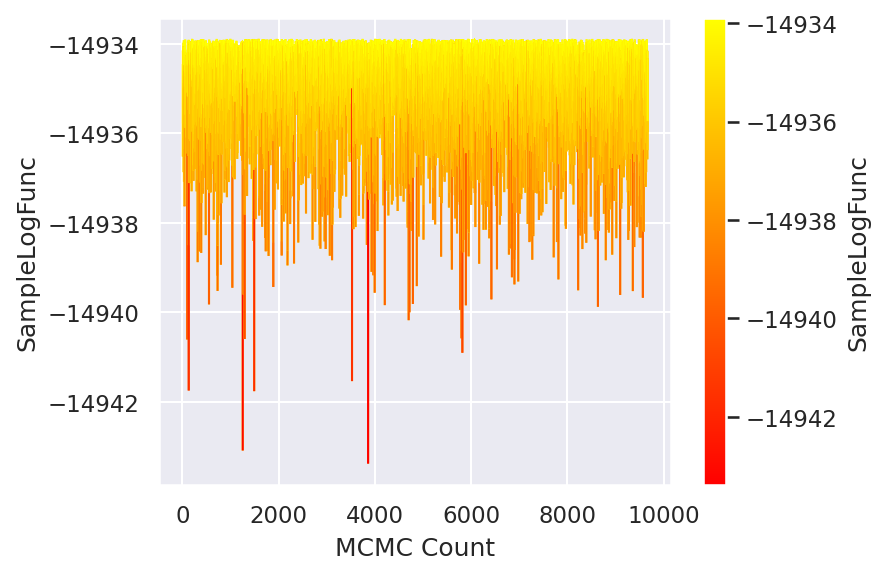

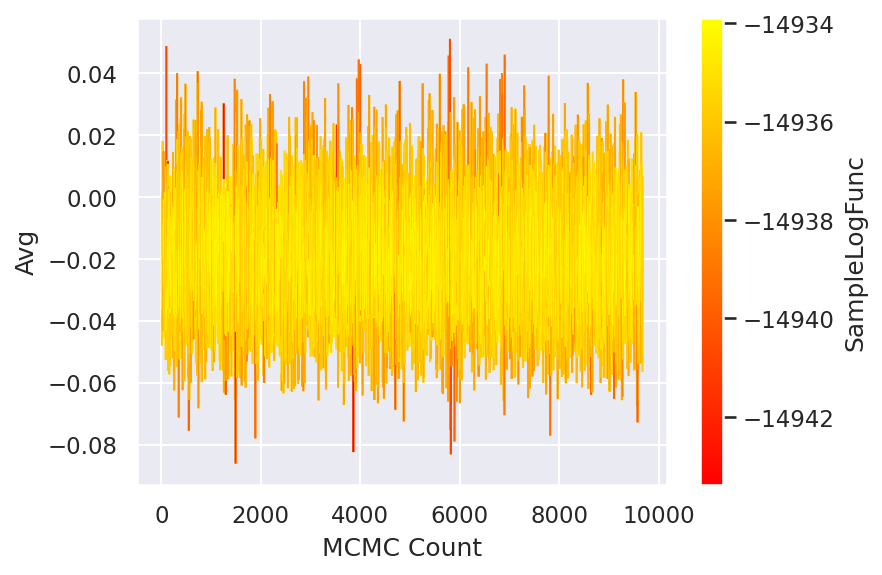

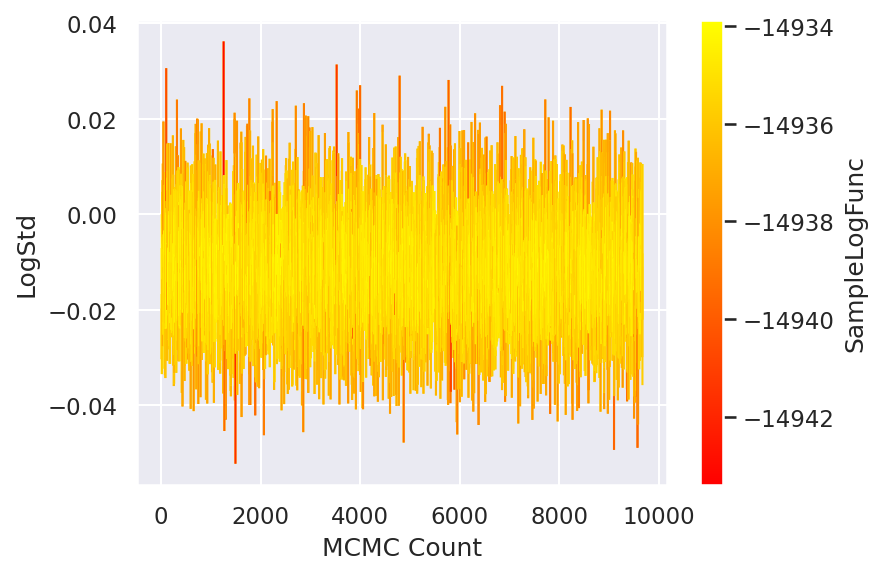

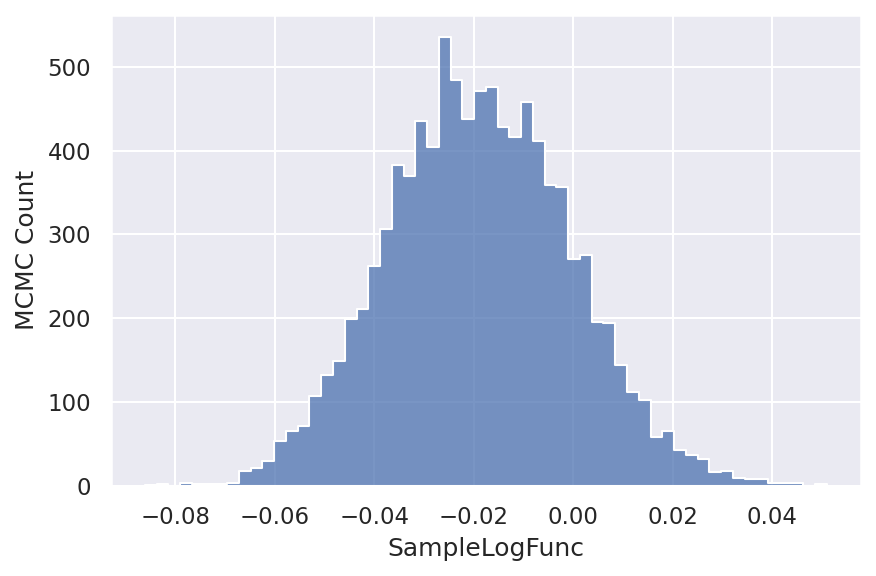

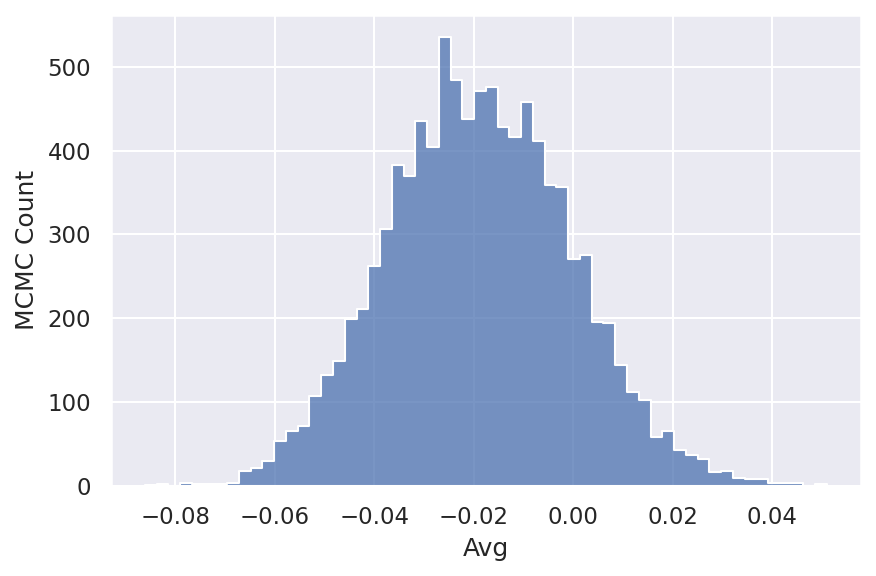

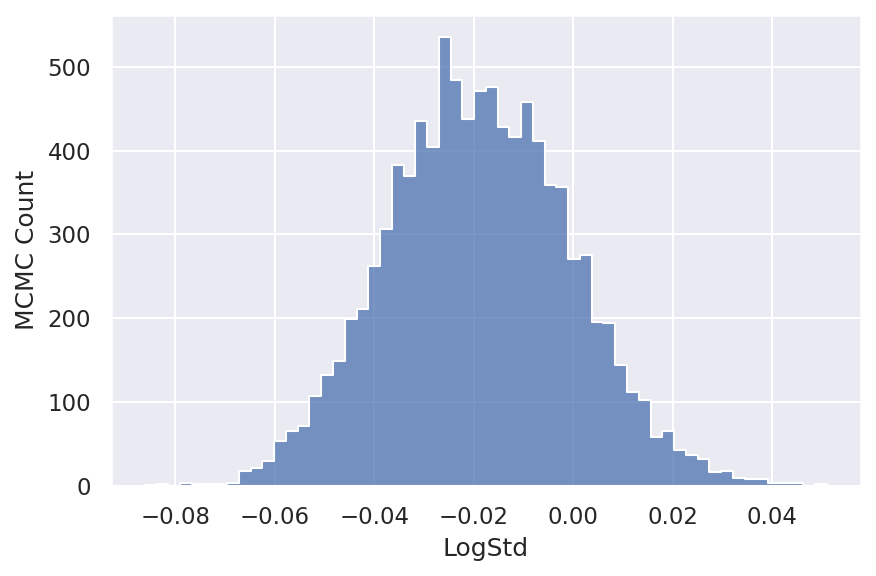

In [106]:
# read the resulting sample including TrunctNormCDF

sample = pmpd.readSample(renabled = True)[0]

# plot traceplots of the sampled parameters

for colname in sample.df.columns:
    sample.plot.line.ycolumns = colname
    sample.plot.line.outputFile = "traceplot_" + colname
    sample.plot.line()
    sample.plot.line.currentFig.axes.set_xlabel("MCMC Count")
    sample.plot.line.currentFig.axes.set_ylabel(colname)

# plot the histograms of the sampled parameters

for colname in sample.df.columns:
    sample.plot.histplot.columns = colname
    sample.plot.histplot.outputFile = "histogram_" + colname
    sample.plot.histplot()
    sample.plot.histplot.currentFig.axes.set_xlabel(colname)
    sample.plot.histplot.currentFig.axes.set_ylabel("MCMC Count")
    

In [107]:
sample.df

,SampleLogFunc,Avg,LogStd
0,-14934.452,0.000000,0.000000
1,-14934.452,0.000000,0.000000
2,-14934.452,0.000000,0.000000
3,-14934.452,0.000000,0.000000
4,-14934.452,0.000000,0.000000
...,...,...,...
9664,-14934.812,-0.000520,-0.008189
9665,-14935.973,0.003520,-0.010985
9666,-14934.318,-0.034029,-0.022033
9667,-14935.729,0.006744,0.010502


In [114]:
lstd = sample.df["LogStd"].mean()
mean = sample.df["Avg"].mean()

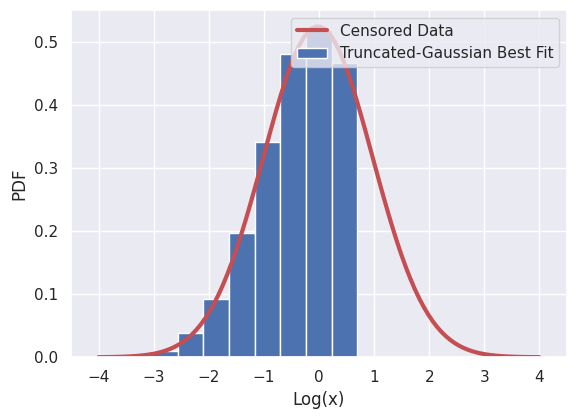

In [125]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize =(6.4,4.6), dpi =100)
ax = plt.subplot()
ax.hist( ldata
        ,density =True
       )
xval = np.linspace(-4,4,100)
yval = np.exp(getLogPDF(xval, mean, lstd)) #used GetLogPDF without cutoff
ax.plot( xval
        ,yval * 5.2/4
        ,color ='r'
        ,linewidth =3
       )
ax.set_xlim([-4.5,4.5])
ax.set_xlabel("Log(x)")
ax.set_ylabel("PDF")
plt.legend(["Censored Data", "Truncated-Gaussian Best Fit"], loc ='upper right')
